### Probabilistic estimation of speed-of-sound anisotropy in trasversely isotropic tissue with pulse-echo ultrasound

----------------------------------

#### (1) We assume elliptical anisotropy, which has experimentally been observed in muscle tissue.

#### (2) We consider a setup with a flat reflector located in front of the ultrasound probe, with tissue in between.

#### (3) We apply Bayesian inference and calculate the posterior distribution of anisotropy parameters. This is useful for uncertainty quantification.


--------------------------------------------------


If you find this work useful for your research, please cite:

Korta Martiartu et al, "Ultrasound longitudinal-wave anisotropy estimation in muscle tissue", TechRxiv, 2021. https://www.techrxiv.org/articles/preprint/Ultrasound_longitudinal-wave_anisotropy_estimation_in_muscle_tissue/15104529


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos,sin,pi,exp,log, atan
import numpy.matlib
from numba import jit
from numpy.random import seed
from numpy.random import randn,uniform
import matplotlib

matplotlib.rcParams.update({'font.size': 20})

### Define forward problem

In [2]:
@jit(nopython=True)

# Define the forward problem (Equation (12) from Korta Martiartu et al. 2021)

def Forward(D,rx,sx,m,alpha):
    
    """
    Function to compute first-arrival reflection traveltimes in homogeneous anisotropic media
    :param D: probe-reflector distance [scalar]
    :param rx: receiver locations [vector, np.array, size: number of receivers]
    :param sx: source locations [vector, np.array, size: number of sources]
    :param m: model parameters describing anisotropic tissue [vector, np.array, 
                size: 5 (2 velocities, anisotropy anlge, and 2 reflector inclination angles)]
    :param alpha: reflector inclination angle [scalar]
    :return: ttt: traveltimes for each source-receiver combination [vector, np.array, 
                    size: number of sources x number of receivers]
    """
    
    RX = np.reshape(np.repeat(rx,len(sx)),(nr,len(sx))).T    # vectorize receiver positions for each source

    SX = np.reshape(np.repeat(sx,nr),(len(sx),nr))           # vectorize source positions for each receiver location
    
    d = RX - SX                                              # source-receiver offset
    
    D = D * cos(alpha) + (SX-rx[0])*sin(alpha)               # eq. (11)
    
    
    # compute traveltimes for each source-receiver combination (eq. (12))
    ttt = np.sqrt(d*d*(m[0]*m[0]*sin(m[2])**2 + m[1]*m[1]*cos(m[2])**2)/(m[0]*m[0]*m[1]*m[1]) + 
                   (4*D*D + 4*D*d*sin(alpha))/(m[0]*m[0]*sin(m[2] + alpha)**2 + m[1]*m[1]*cos(m[2] + alpha)**2))
    
    return ttt.flatten()


### Define Prior

In [3]:
# Define prior pobability density function

def Prior(m):
    
    """
    Function computing the prior probality for given model parameters.
    :param m: model parameters describing anisotropic tissue [vector, np.array, size: 5 (2 velocities, 
                anisotropy anlge, and 2 reflector inclination angles)]
    :return: prob: prior probability for m [scalar]
    """
    
    v_max = 1800   #uniform prior velocities
    v_min = 1300

    phi_max = 45*pi/180   #uniform prior anisotropy angle
    phi_min = -45*pi/180
    
    alpha1_mean = 5 *pi/180   # gaussian prior reflector inclination angle
    alpha2_mean = 10 *pi/180
    alpha_std2 = 3*3*pi*pi/180/180
    
    # Define probabilities
    
    if ((sum(m[0:2] > v_max) >= 1) | (sum(m[0:2] < v_min) >= 1) | (m[2] >= phi_max) | (m[2] < phi_min)):
        
        prob = 0
        
    else:
        
        prob = ((1 / (v_max - v_min))*(1 / (v_max - v_min)) *(1 / (phi_max - phi_min)) *
               exp(-0.5*((m[3] - alpha1_mean)**2)/alpha_std2) * 
                exp(-0.5*((m[4] - alpha2_mean)**2)/alpha_std2))
    
    return prob

### Define Likelihood

In [4]:
# We assume Gaussian noise with standard deviation of 1e-3 of the maximum traveltimes in each dataset

def Likelihood(ttt_obs,ttt,ns):
    
    """ 
    Function computing data likelihood for given traveltime predictions using two reflector inclination angles.
    :param ttt_obs: observed traveltimes [vector, np.array, size: 2*ns x nr, nr: number of receivers]
    :param ttt: predicted traveltimes [vector, np.array, size: 2*ns x nr, nr: number of receivers]
    :param ns: number of sources [scalar]
    :return: exponent: exponent of the data likelihood [scalar] 
    """

    nr = int(len(ttt_obs)/2/ns) # number of receivers (we use 2 inclination angles)
    
    # Define standard deviation of the measurements noise  
    sigma = np.ones_like(ttt_obs)
    
    for i in range(ns):
        sigma[i*nr:(i+1)*nr] = 1e-3 * max(ttt_obs[i*nr:(i+1)*nr])
        sigma[(ns+i)*nr:(ns + i+1)*nr] = 1e-3 * max(ttt_obs[i*nr:(i+1)*nr])
  
       
    exponent = -0.5*(np.linalg.norm((ttt_obs-ttt)/sigma)**2) # Exponent of the likelihood
       
    return exponent

### Modify current model

In [5]:
## Define function to suggest new samples. 
## These are created randomly from a normal distribution around previously accepted model.

def Modify_model(m):
    
    """
    Function to randomly update model parameters in the vecinity of m in each MCMC iteration.
    :param m: model parameters describing anisotropic tissue [vector, np.array, size: 5 (2 velocities, anisotropy anlge, 
    and 2 reflector inclination angles)]  
    :return: m_new: update model [vector, np.array, size: 5]
    """
    
    m_new = m + randn(len(m))*np.array([0.1, 0.05, 0.05*pi/180, 0.01*pi/180, 0.01*pi/180])   
    
    return m_new

### Define Acceptance Rule

In [6]:
def Acceptance_rule(prior,prior_new,L,L_new):
    
    """
    Function defining the acceptance rule for newly suggested model. If the posterior of the new model is increased,
    accept the model; if not, accept the model according to a uniform probability.
    :param prior: prior previously accepted model [scalar]
    :param prior_new: prior proposed model [scalar]
    :param L: Likelihood previously accepted model [scalar]
    :param L_new: Likelihood proposed model [scalar]
    :return: Boolean
    """
    
    if (L_new + np.log(prior_new) > L + np.log(prior)): # if posterior prob is higher, accept
        
        return True
    
    else:  #if not, accept the model according to random uniform value
        
        accept = uniform()      

        return accept < (prior_new/prior)*np.exp(L_new-L)
    

### Inputs for forward problem


In [7]:
D = 0.1                         # probe-reflector distance [cm]. In muscle: [0.10,0.05]
sx = 0.02                       # position source
nr = 128                        # number of receivers.
rx0 = 0.02                      # x-value of first receiver.
rx1 = 0.06                      # x-value of last receiver.

rx = np.linspace(rx0, rx1, nr)  # receiver positions

### Inputs for MCMC

In [8]:
n_samples = 1000000   # total number of samples while sampling the posterior

burn_in = 10000       # length of the burn-in period

#### Generate/load observed data

In [9]:
m_true = np.array([1560, 1540, 5*pi/180, 0*pi/180, 5*pi/180])       # Define true model


ttt_obs = np.hstack((Forward(D,rx,rx[::4],m_true[0:3], m_true[3]), 
                     Forward(D,rx,rx[::4],m_true[0:3], m_true[4]))) # Compute observed traveltimes


#### Generate initial model, prior and likelihood

In [10]:
m = np.array([1540, 1540, 5*pi/180, 0*pi/180, 5*pi/180]) # initial model

prior = Prior(m) # prior initial model

L = Likelihood(ttt_obs,np.hstack((Forward(D,rx,rx[::4],m[:3], m[3])
                                  ,Forward(D,rx,rx[::4],m[:3], m[4]))), len(rx[::4])) # Likelihood initial model

print(m, prior, L)

[1.54000000e+03 1.54000000e+03 8.72664626e-02 0.00000000e+00
 8.72664626e-02] 1.583312182782686e-07 -570.4384126627846


### MCMC algorithm

In [11]:
%%time

n = 0
k_accepted = 1

m_array = np.zeros((n_samples - burn_in, len(m) + 2)) # initialize arrays where the samples are stored
m_array2 = np.zeros((n_samples, len(m) + 2))


for i_sample in range(n_samples):
    
    m_new = Modify_model(m) # propose a new model
    
    prior_new = Prior(m_new) # prior new model
    
    L_new = Likelihood(ttt_obs,np.hstack((Forward(D,rx,rx[::4],m_new[:3], m_new[3]),
                                          Forward(D,rx,rx[::4],m_new[:3], m_new[4]))), len(rx[::4])) # likelihood new model

    
    if Acceptance_rule(prior,prior_new,L,L_new): # is it accepted?
   
        m = m_new
        L = L_new
        prior = prior_new
        k_accepted += 1
       
        
    
    if (burn_in <= i_sample): # store the models after burn-in period
        
            m_array[n,:]=[m[0], m[1], m[2], m[3], m[4], L, prior]
            n += 1

    m_array2[i_sample,:]=[m_new[0], m_new[1], m_new[2], m_new[3], m_new[4], L_new, prior_new] #store all models
    

    
m_array[:,2:5] = m_array[:,2:5]*180/pi # change angles to degrees
m_array2[:,2:5] = m_array2[:,2:5]*180/pi 

CPU times: user 12min 26s, sys: 345 ms, total: 12min 26s
Wall time: 12min 26s


#### Save results

In [12]:
filename = f'./Posterior_{n_samples}samples_{burn_in}burnin'

with open(filename, 'wb') as f:
    np.savez(f, m_array = m_array, m_true = m_true, D = D, 
             rx0 = rx0, rx1 = rx1, nr = nr, sx = sx)
   

#### Acceptance rate:

In [13]:
k_accepted/n_samples*100

18.412300000000002

Text(0, 0.5, 'Likelihood')

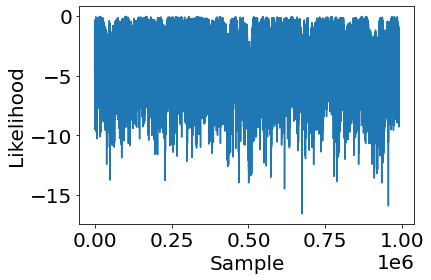

In [22]:
plt.plot((m_array[:,5])) # plot likelihood

plt.xlabel('Sample')
plt.ylabel('Likelihood')

#### Example marginal posterior probability density function

Text(0, 0.5, '$\\pi(v_1|\\mathbf{d}_{obs})$')

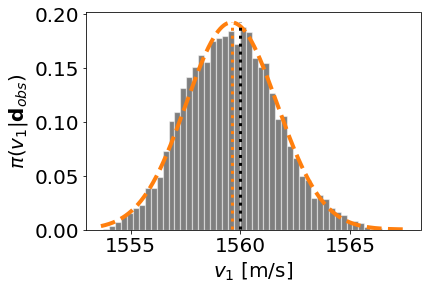

In [14]:
# Histogram

n, bins, patches = plt.hist(m_array[::100,0], 50, facecolor='black', density=True, stacked = True, alpha=0.5,
                           edgecolor='white', linewidth=1.2)

# Compute Gaussian approximation

m0 = np.mean(m_array[::100,0])
mu = np.var(m_array[::100,0])

x = np.linspace(np.min(m_array[:,0]),np.max(m_array[:,0]), 1000)
pdf = 1.0/np.sqrt(2*np.pi*mu)*np.exp(-0.5*(x-m0)**2/mu)

# Plot 

plt.plot(x,pdf,'--',linewidth = 4)

plt.plot(m_true[0]*np.ones(100),np.linspace(min(pdf),max(pdf),100),':k', linewidth = 3)

plt.plot(m0*np.ones(100),np.linspace(min(pdf),max(pdf),100),':', color='tab:orange', linewidth = 3)


plt.xlabel('$v_1$ [m/s]')
plt.ylabel('$\pi(v_1|\mathbf{d}_{obs})$')